In [12]:
import numpy as np
import matplotlib.pyplot as plt


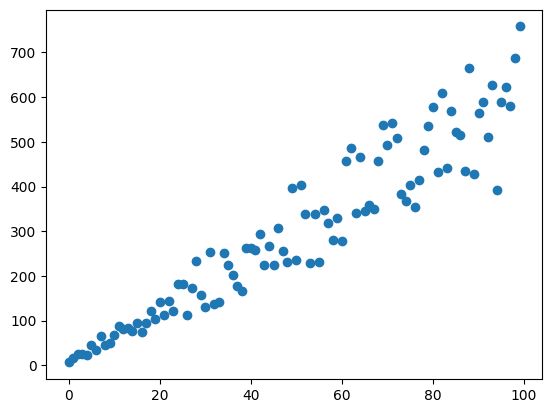

In [16]:
a = 4
b = 6

X = np.array(range(100)) 
Y_true = (a * X + b) * (1 + np.random.rand(100))

plt.scatter(X, Y_true)

In [15]:
def MSE(Y, Y_hat):
    return np.sum((Y - Y_hat)**2)

print(MSE(Y_true, Y_true))

0.0


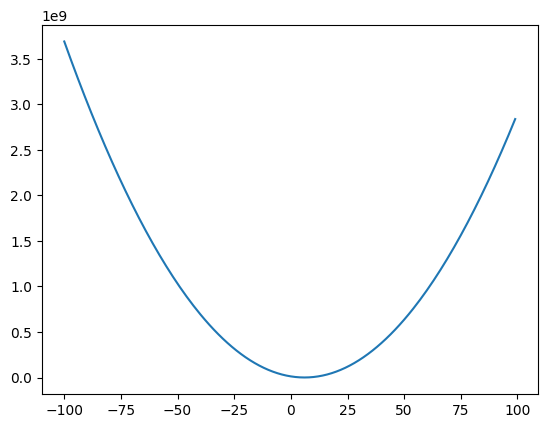

In [23]:
A = np.arange(-100, 100)

errors = [MSE(i * X + b, Y_true) for i in A]
plt.plot(A, errors)